# 2.0 Feature Engineering
## 2.3 Feature Selection Process

1. Feature Selection based on feature importance experiments
2. Feature Selection based on domain application (upper vs lower body)

In [263]:
import pandas as pd
from sklearn.preprocessing import minmax_scale 

data = pd.read_csv("data/training-selected/all/pose_data_augmented_z_res_0301.csv")

p_labels = data['label_encoded'].values
d_labels = data['difficulty'].values

features = pd.concat([data.iloc[:, 6:9], data.iloc[:, 39:93], data.iloc[:, 105:]], axis=1)
feature_names = features.columns

weights = pd.read_csv("feature_weights_20240311.csv")

weights_dict = {
    "logr": minmax_scale(weights['logr'].tolist()),
    "gini": minmax_scale(weights['gini'].tolist()),
    "permutation": minmax_scale(weights['permutation'].tolist()),
    "shap": minmax_scale(weights['shap'].tolist())
}

feature_sets = {}

for model_name, weights in weights_dict.items():
    model_features_scores = sorted(enumerate(weights), key=lambda x: x[1], reverse=True)
    top_features_indices = [index for index, score in model_features_scores[:10]]
    feature_sets[model_name] = [feature_names[index] for index in top_features_indices]

In [264]:
manual_selection = {
    'upper1': ['landmark_11_y','landmark_12_y','landmark_13_y','landmark_14_y','landmark_15_y','landmark_16_y',],
    'upper2': ['chest_y','chest_y','hip_y','a_lft_shoulder_to_wrist','a_rgt_shoulder_to_wrist','a_nose_to_rgt_shoulder','a_nose_to_lft_shoulder','d_wrists','d_elbows'],
    'lower1': ['landmark_23_y','landmark_24_y','landmark_25_y','landmark_26_y','landmark_27_y','landmark_28_y',],
    'lower2': ['d_nose_to_rgt_knee', 'd_nose_to_lft_knee','d_rgt_shoulder_to_ankle', 'd_lft_shoulder_to_ankle', 'd_wrists',
               'd_elbows', 'd_knees', 'd_ankles','a_mid_hip_to_knees','a_lft_hip_to_ankle','a_rgt_hip_to_ankle']
}

feature_sets.update(manual_selection)
print(feature_sets)

{'logr': ['landmark_00_y', 'a_lft_hip_to_ankle', 'landmark_21_y', 'stomach_y', 'landmark_28_y', 'chest_y', 'landmark_24_y', 'landmark_12_y', 'landmark_18_y', 'a_lft_shoulder_to_wrist'], 'gini': ['stomach_y', 'hip_y', 'chest_y', 'landmark_00_y', 'd_elbows', 'd_wrists', 'landmark_24_y', 'd_rgt_shoulder_to_ankle', 'd_ankles', 'd_knees'], 'permutation': ['a_rgt_hip_to_ankle', 'a_rgt_shoulder_to_wrist', 'd_knees', 'a_lft_hip_to_ankle', 'd_lft_shoulder_to_ankle', 'd_ankles', 'a_mid_hip_to_knees', 'd_rgt_shoulder_to_ankle', 'd_wrists', 'a_lft_shoulder_to_wrist'], 'shap': ['landmark_27_y', 'landmark_00_y', 'hip_y', 'd_lft_shoulder_to_ankle', 'landmark_24_y', 'landmark_26_y', 'a_rgt_hip_to_ankle', 'a_mid_hip_to_knees', 'landmark_14_y', 'a_lft_hip_to_ankle'], 'upper1': ['landmark_11_y', 'landmark_12_y', 'landmark_13_y', 'landmark_14_y', 'landmark_15_y', 'landmark_16_y'], 'upper2': ['chest_y', 'chest_y', 'hip_y', 'a_lft_shoulder_to_wrist', 'a_rgt_shoulder_to_wrist', 'a_nose_to_rgt_shoulder', 'a_n

## 2.4 Feature Relationship Observations

For this example, we focus on similar grip styles and see the relationship between importance features based on models vs. manual selection (which represents domain knowledge).

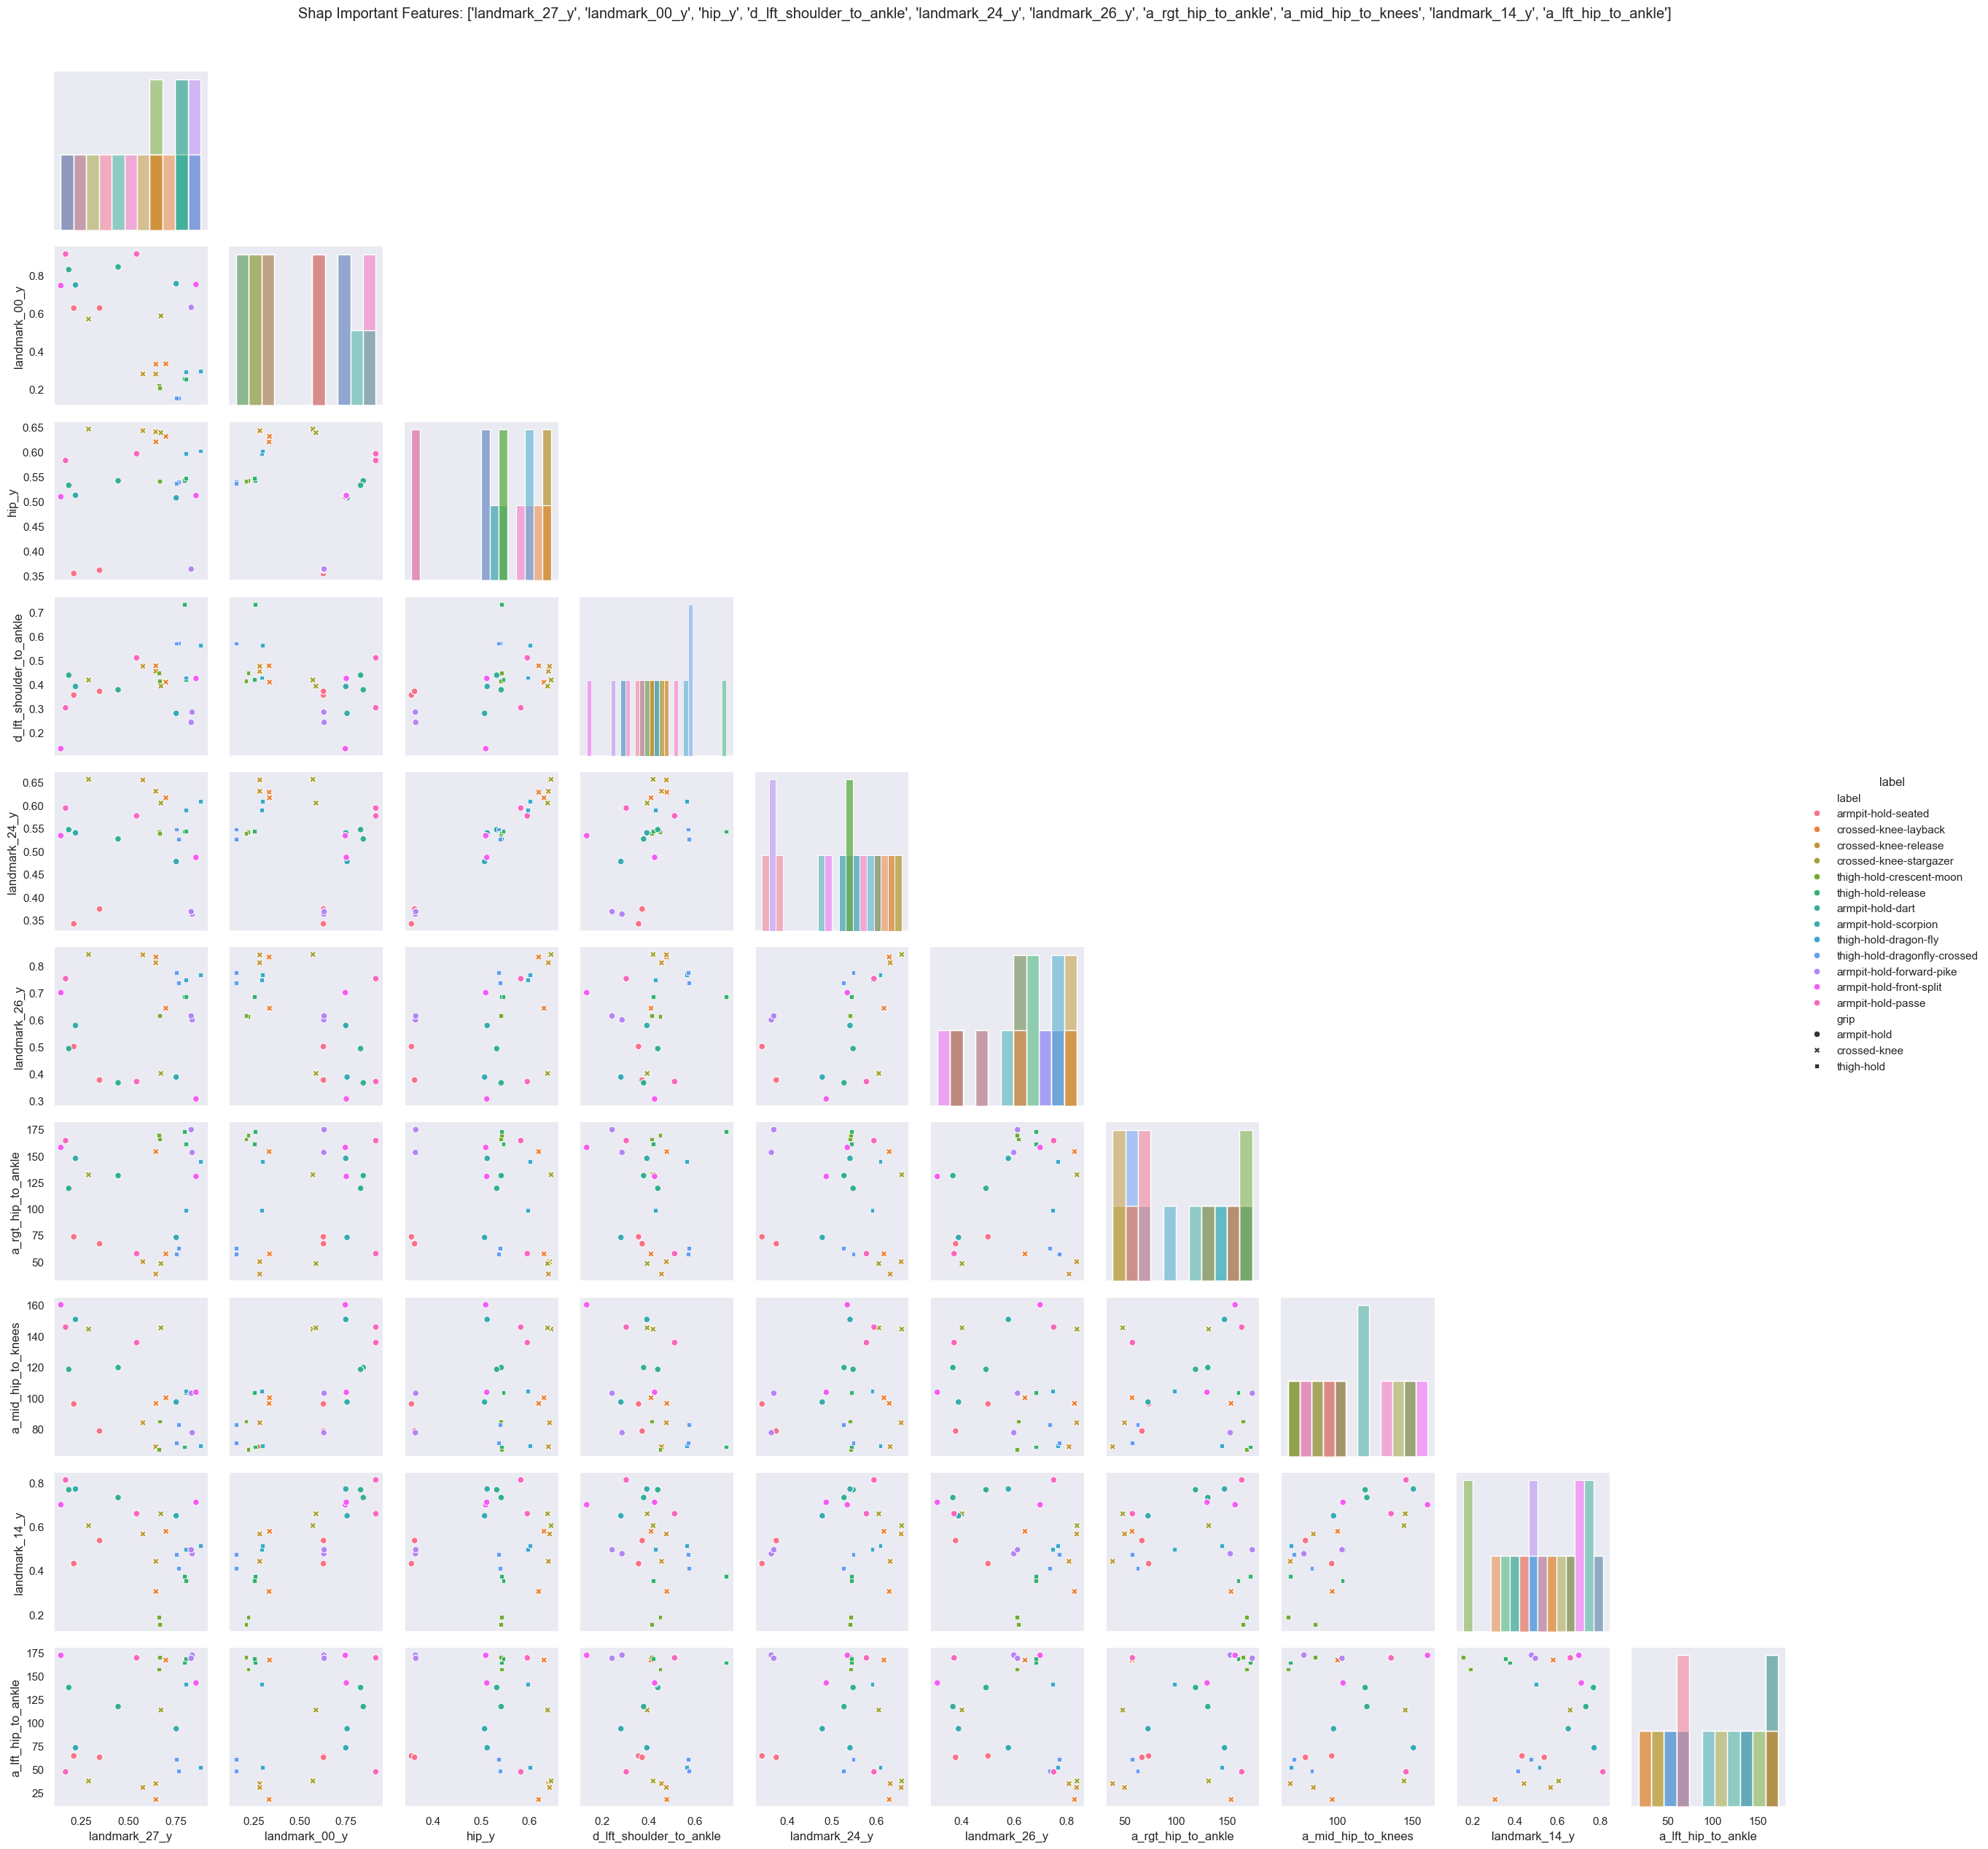

In [265]:
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

def pairgrid_by_model(top_features, model_name, input_keywords=[]):
    data = pd.read_csv("data/training-selected/all/pose_data_augmented_z_res_0301.csv")
    
    if len(input_keywords) != 0:
        filtered_data = data[data['label'].str.contains('|'.join(input_keywords), na=False)]
        data = filtered_data
        
    data['grip'] = None
    
    for keyword in input_keywords:
        data.loc[data['label'].str.contains(keyword, na=False), 'grip'] = keyword
    
    selected = top_features[model_name] + ['label']
    
    g = sns.PairGrid(data[selected + ['grip']], hue='label', corner=True)
    g = g.map_offdiag(sns.scatterplot, hue=data['label'], style=data['grip'])    
    g = g.map_diag(sns.histplot, hue=data['label'])
    g.add_legend()
    plt.suptitle(f"{model_name.capitalize()} Important Features: {top_features[model_name]}", y=1.02)
    plt.savefig(f"figures/pairplot_{model_name}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png")
    plt.show()

input_keywords = ["crossed-knee","thigh-hold","armpit-hold"]

pairgrid_by_model(feature_sets, "shap", input_keywords)

## LDA

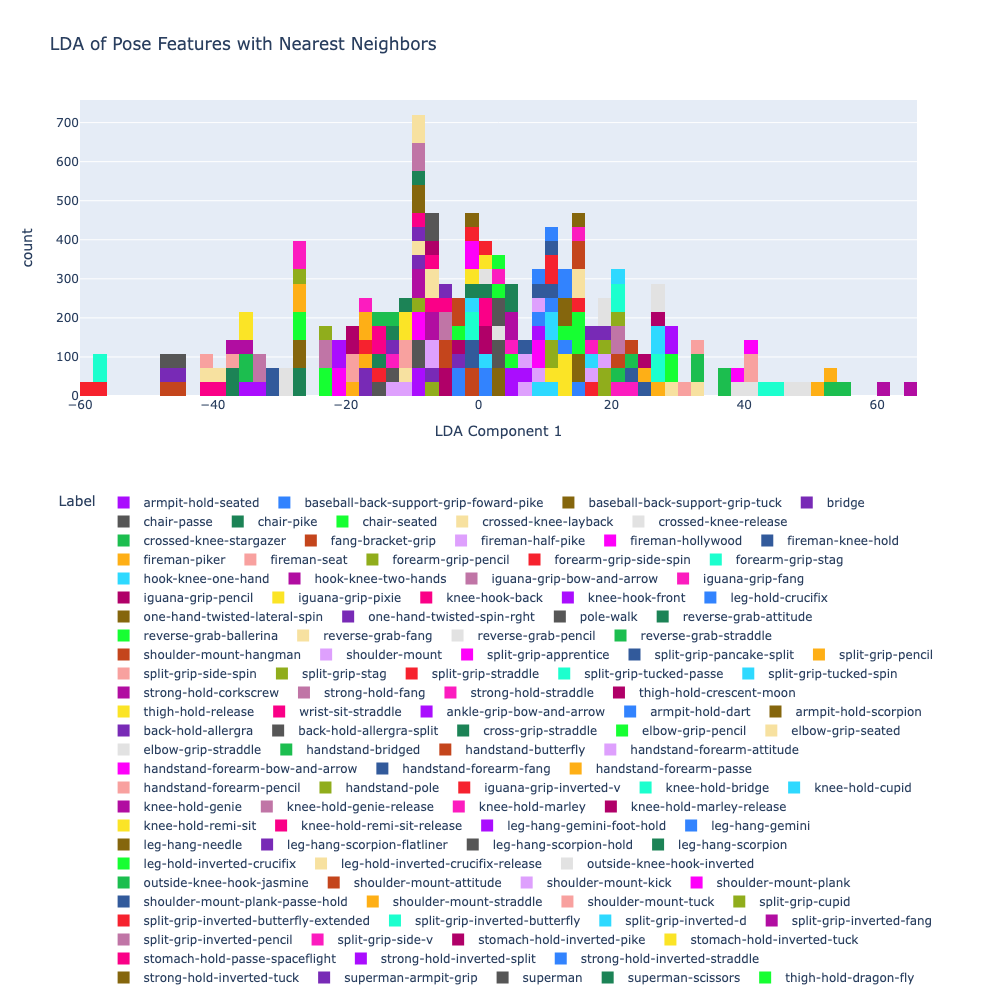

In [204]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import pandas as pd
import numpy as np

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_selection1)

n_components = 1
lda = LinearDiscriminantAnalysis(n_components=n_components)
X_lda = lda.fit_transform(X_scaled, y)

# Make sure the color palette is large enough for all classes
unique_labels = np.unique(pose_classes)
palette = px.colors.qualitative.Alphabet
# Extend the palette if there are not enough colors
color_discrete_sequence = (palette * (len(unique_labels) // len(palette) + 1))[:len(unique_labels)]

df_vis = pd.DataFrame(X_lda, columns=[f'LDA{i+1}' for i in range(n_components)])
df_vis['Label'] = pose_classes

# Create figures for either 1 or 2 LDA components
if n_components == 1:
    fig = px.histogram(df_vis, x='LDA1', color='Label',
                       title="LDA of Pose Features with Nearest Neighbors",
                       color_discrete_sequence=color_discrete_sequence)
    # Adjust for histogram
    fig.update_layout(
        xaxis_title="LDA Component 1",
        xaxis={'categoryorder':'total descending'}
    )
    fig.update_xaxes(categoryorder='total descending')
    
elif n_components == 2:
    fig = px.scatter(df_vis, x='LDA1', y='LDA2', color='Label',
                     title="LDA of Pose Features with Nearest Neighbors",
                     color_discrete_sequence=color_discrete_sequence)
    # Adjust for scatter plot
    fig.update_layout(
        xaxis_title="LDA Component 1",
        yaxis_title="LDA Component 2",
    )

elif n_components == 3:
    df_vis = pd.DataFrame(X_lda, columns=['LDA1', 'LDA2', 'LDA3'])
    df_vis['Label'] = pose_classes
    fig = px.scatter_3d(df_vis, x='LDA1', y='LDA2', z='LDA3', color='Label',
                        title="3D LDA of Pose Features with Nearest Neighbors",
                        color_discrete_sequence=color_discrete_sequence)
    # Adjust for 3D scatter plot
    fig.update_layout(
        scene=dict(
            xaxis_title='LDA Component 1',
            yaxis_title='LDA Component 2',
            zaxis_title='LDA Component 3'
        ),
    )
else:
    print("only 1,2 or 3")

# Common layout updates
fig.update_layout(
    legend=dict(yanchor='bottom', xanchor='center', y=-2, x=0.5, orientation='h'),
    height=1000,
    width=1000,
)

# Show the plot
fig.show()

In [205]:
from sklearn.preprocessing import MinMaxScaler

class_means = df_vis.groupby('Label')['LDA1'].mean().reset_index()

# 2. Normalize the values based on min and max values
#scaler = MinMaxScaler()
#class_means['LDA1_normalized'] = scaler.fit_transform(class_means[['LDA1']])

knn = KNeighborsClassifier(n_neighbors=20, metric='euclidean', weights='distance')
knn.fit(class_means[['LDA1']], class_means['Label'])

KNeighborsClassifier(metric='euclidean', n_neighbors=20, weights='distance')

In [206]:
class_means

,Label,LDA1
0,ankle-grip-bow-and-arrow,5.543133
1,armpit-hold-dart,14.208088
2,armpit-hold-forward-pike,14.268542
3,armpit-hold-front-split,17.714337
4,armpit-hold-passe,39.940121
...,...,...
136,thigh-hold-dragonfly-crossed,14.779576
137,thigh-hold-release,12.562318
138,tuck-hold,26.551379
139,twisted-grip-inverted-straddle,53.697522


In [207]:
distances, indices = knn.kneighbors(class_means[['LDA1']].values)

def get_closest_classes(row_idx, indices, labels, num_closest=3):
    closest_classes = []
    for neighbor_idx in indices[row_idx][1:num_closest+1]:  # Skip the first one since it's the class itself
        closest_classes.append(labels[neighbor_idx])
    return closest_classes

class_means['Closest Classes'] = [get_closest_classes(i, indices, class_means['Label'].values) for i in range(len(class_means))]
class_means[['Label', 'Closest Classes']]

/usr/local/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



,Label,Closest Classes
0,ankle-grip-bow-and-arrow,"[handstand-onehand, split-grip-backward-split,..."
1,armpit-hold-dart,"[armpit-hold-forward-pike, elbow-grip-pencil, ..."
2,armpit-hold-forward-pike,"[armpit-hold-dart, elbow-grip-pencil, armpit-h..."
3,armpit-hold-front-split,"[shoulder-mount-princess-grip-straddle, handst..."
4,armpit-hold-passe,"[crossed-knee-release, shoulder-mount-tuck, ha..."
...,...,...
136,thigh-hold-dragonfly-crossed,"[armpit-hold-scorpion, elbow-grip-pencil, armp..."
137,thigh-hold-release,"[iguana-grip-pixie, leg-hang-needle, strong-ho..."
138,tuck-hold,"[split-grip-inverted-d, split-grip-inverted-bu..."
139,twisted-grip-inverted-straddle,"[elbow-grip-fang, outside-knee-hook-inverted, ..."


In [208]:
class_means.to_csv("knn_closes_classes2.csv", index=False)

## Results

1. Overall, all feature pairs do not have clear class boundaries based on their assigned difficulty level. Class separability between 2 and 3 (intermediate and advanced) where class 1 is found in between. This could mean that those feature combinations might not be strong predictors for distinguishing between classes on their own or might require more complex decision boundaries than linear separability.